# Imports/Pick Analyses to run

In [ ]:
import warnings

import mne
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import itertools
import pandas as pd
from collections import defaultdict
from collections import Counter
import re
import seaborn as sns
from statsmodels.formula.api import mixedlm
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

from preprocess_nirs import *

from mne_nirs.channels import picks_pair_to_idx, get_long_channels
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed
from mne.preprocessing.nirs import source_detector_distances, scalp_coupling_index
from mne_connectivity import spectral_connectivity_epochs, spectral_connectivity_time
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm, statsmodels_to_results
from mne_nirs.visualisation import plot_glm_group_topo

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Set the image dpi
dpi = 600

# Set the number of cores to use
n_jobs = 1
if os.cpu_count() is not None:
    n_jobs = int(np.ceil(os.cpu_count() * 0.75))

# Preprocess the data
process_data = False
sci_threshold = 0.7
cv_threshold = 15
good_threshold = 0.7

# Get the participant info plots
get_participant_age_head_size_plot = False
get_meas_dates_plot = False

# Get the non windowed SCI and CV measure
get_full_sci = False
get_full_cv = False

# Get the peak power/scalp coupling index dataframes
get_peak_power_sci_df = False
peak_power_threshold = 0.1
get_good_windows_plot = False
get_slope_pp_sci_plot = False
get_head_size_vs_sci_plot = False
get_across_participant_sci_plots = False
get_participant_sci_plots = False

# Get the epochs
get_epochs = False
get_face_type_emotion_epochs = False

# Get the GLM data/plots
get_glm_analysis = False
get_ind_glm_plots = False
get_group_glm_plots = False
get_group_contrast_plots = False

# Get the average timeseries activity
get_roi_timeseries_activity = False

# Get the ERP plots
get_erp_plots = False

# Get the connectivity data
run_ind_connectivity = False
get_ind_con_plots = False
get_condition_con_plots = False
run_group_level_t_tests = False
get_group_level_t_tests_roi__chord_plots = True

# Run decoding analysis
run_raw_data_decoding = False
run_connectivity_decoding = False
get_decoding_table_scores = False

# Get Participants

In [2]:
# Define the folder path
data_path = os.path.join(os.getcwd(), 'data')

# Get a list of paths of all the subfolders of the folders labeled 'P_1', 'P_2', etc.
participants = [os.path.join(data_path, f) for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

participants_with_same_order = []

# remove participants P_1 to P_11 but keep P_10, and P_12 onwards
# P_1 to P_11 have the same order of faces, and P_86 and P_87 have the same order of faces
for i in range(1, 12):
    if i != 10:
        participants_with_same_order.append(os.path.join(data_path, f'P_{i}'))
        #participants.remove(os.path.join(data_path, f'P_{i}'))

participants_with_same_order.append(os.path.join(data_path, f'P_87'))
#participants.remove(os.path.join(data_path, f'P_87'))

# remove participants P_13 due to not recording
participants.remove(os.path.join(data_path, f'P_13'))

# remove participants P_50 due to ending early
participants.remove(os.path.join(data_path, f'P_50'))

# participant P_54 used their phone
participants.remove(os.path.join(data_path, f'P_54'))

# Search recursively for the folder with the .snirf extension
fnirs_folders = []
for participant in participants:
    for root, dirs, files in os.walk(participant):
        for file in files:
            if file.endswith('.snirf'):
                fnirs_folders.append(root)
                break

# Preprocessing

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    raws = []
    raw_ods = []
    raw_haemos = []

    if process_data:
        # Load the snirf files
        for folder in fnirs_folders:
            # find all the .snirf files in the folder but get the full path
            snirf_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.snirf')]
            if len(snirf_files) == 0:
                print(f"No .snirf files found in {folder}")
                continue
            elif len(snirf_files) > 1:
                raise Exception(f"Multiple .snirf files found in {folder}")
            else:
                raw = mne.io.read_raw_snirf(snirf_files[0], optode_frame='mri', preload=True, verbose=False)
            
            # find all the 'description.json' files in the folder but get the full path
            description_files = [f for f in os.listdir(folder) if 'description.json' in f]
            if len(description_files) == 0:
                print(f"No description.json files found in {folder}")
                continue
            elif len(description_files) > 1:
                raise Exception(f"Multiple description.json files found in {folder}")
            else:
                description = json.load(open(os.path.join(folder, description_files[0])))

            # add the description to the raw object
            raw.info['description'] = str(description)
            raws.append(raw)

        # sort the raws by the measurement date
        raws = sorted(raws, key=lambda x: x.info['meas_date'])

        i = 1
        for raw in raws:
            raw_od, raw_haemo = preprocess_data(raw)
            raw_ods.append(raw_od)
            raw_haemos.append(raw_haemo)
            i += 1

        # clear any files in each folder
        for folder in ['processed_data/raws', 'processed_data/raw_ods', 'processed_data/raw haemos']:
            for f in os.listdir(folder):
                os.remove(os.path.join(folder, f))

        for i, (raw, raw_od, raw_haemo) in enumerate(zip(raws, raw_ods, raw_haemos), 1):
            # save raw as a fif file
            raw.save(f'processed_data/raws/raw{i}.fif', overwrite=True, verbose=False)

            # save raw_od as a fif file
            raw_od.save(f'processed_data/raw_ods/raw_od{i}.fif', overwrite=True, verbose=False)

            # save raw_haemo as a fif file
            raw_haemo.save(f'processed_data/raw haemos/raw_haemo{i}.fif', overwrite=True, verbose=False)
        
        raws = []
        raw_ods = []
        raw_haemos = []

    # count how many files are in the processed_data/raw_haemos folder
    processed_data_count = len([f for f in os.listdir('processed_data/raw haemos') if f.endswith('.fif')])

    # Load the processed data
    for i in range(1, processed_data_count + 1):
        raw = mne.io.read_raw_fif(f'processed_data/raws/raw{i}.fif', preload=True, verbose=False)
        raws.append(raw)

        raw_od = mne.io.read_raw_fif(f'processed_data/raw_ods/raw_od{i}.fif', preload=True, verbose=False)
        raw_ods.append(raw_od)

        raw_haemo = mne.io.read_raw_fif(f'processed_data/raw haemos/raw_haemo{i}.fif', preload=True, verbose=False)
        raw_haemos.append(raw_haemo)

# Participant Information

### Participant Age/Head Size Plot

In [4]:
if get_participant_age_head_size_plot:
    # Find the file with description.json as a substring in each subfolder
    description_files = [os.path.join(subfolder, f) for subfolder in fnirs_folders for f in os.listdir(subfolder) if 'description.json' in f]

    # Load the description files
    descriptions = [json.load(open(description_file)) for description_file in description_files]

    # Get the average age of the participants and convert it to a float
    ages = [float(description['age']) for description in descriptions]
    average_age = sum(ages) / len(ages)
    min_age = min(ages)
    max_age = max(ages)
    std_age = np.std(ages)

    # Convert the remarks to a float and get the average
    remarks = [description['remarks'] for description in descriptions]
    # if remark is '', replace it with None
    remarks = [float(remark) if remark != '' else None for remark in remarks]
    average_head_circumference = sum(remark for remark in remarks if remark is not None) / len([remark for remark in remarks if remark is not None])
    std_head_circumference = np.std([remark for remark in remarks if remark is not None])
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Age histogram
    axs[0].hist(ages, bins=40, edgecolor='black')
    axs[0].set_xlabel('Age')
    axs[0].set_ylabel('Number of participants')
    axs[0].set_title(f'Age distribution of participants\n{len(ages)} participants, Mean: {round(average_age, 2)}, Std: {round(std_age, 2)}')

    # Head circumference histogram
    axs[1].hist([remark * 2.54 for remark in remarks if remark is not None], bins=40, edgecolor='black')
    axs[1].set_xlabel('Head circumference (cm)')
    axs[1].set_ylabel('Number of participants')
    axs[1].set_title(f'Head circumference distribution of participants\nMean: {round(average_head_circumference * 2.54, 2)} cm, Std: {round(std_head_circumference * 2.54, 2)} cm')

    # Adjust layout
    plt.tight_layout()
    plt.savefig('plots/participants/participant_info.png', dpi=dpi)
    plt.close()

### Measurement Dates

In [5]:
if get_meas_dates_plot:
    # Extract the measurement dates
    measurement_dates = [raw_haemo.info['meas_date'] for raw_haemo in raw_haemos]

    # Convert to pandas datetime
    measurement_dates = pd.to_datetime(measurement_dates)

    # Create a plot of the measurement dates
    plt.figure(figsize=(15, 10))
    plt.plot(measurement_dates, range(1, len(measurement_dates) + 1), 'o-')
    plt.xlabel('Measurement date')
    plt.ylabel('Participant number')
    plt.title('Measurement dates of participants, N = ' + str(len(measurement_dates)))
    plt.grid()
    plt.tight_layout()
    plt.savefig('plots/participants/measurement_dates.png', dpi=dpi / 4)
    plt.close()

### Short Distance Channels Check

In [6]:
distance_counts = [
    (
        sum(distances < 0.01),
        sum((distances >= 0.01))
    )
    for raw in raws
    for distances in [np.array(source_detector_distances(raw.info))]
]

# Count unique tuples
unique_distance_counts = Counter(distance_counts)

# Display the results
for (short_count, long_count), participant_count in unique_distance_counts.items():
    print(f"{participant_count} participants with {short_count} short channels (< 1 cm) and {long_count} long channels (>= 1 cm)")

48 participants with 4 short channels (< 1 cm) and 206 long channels (>= 1 cm)
39 participants with 16 short channels (< 1 cm) and 206 long channels (>= 1 cm)


# Mapping brain regions

In [7]:
# get the channel names for hbo
ch_names_hbo = [ch_name for ch_name in raw_haemos[0].ch_names if 'hbo' in ch_name]

ch_mapping_hbo = {
    "Left Frontal": [],
    "Right Frontal": [],
    "Left Prefrontal": [],
    "Right Prefrontal": [],
    "Left Parietal": [],
    "Right Parietal": [],
    "Left Occipital": [],
    "Right Occipital": []
}

group_boundaries = [0]

ch_mapping_hbo["Left Frontal"].append('S1_D1 hbo')

ch_mapping_hbo["Left Frontal"].append('S1_D2 hbo')

ch_mapping_hbo["Left Frontal"].append('S1_D17 hbo')

# find the channels that have 'S2_', 'S3_', 'S4_', 'S5_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S2_' in ch_name or 'S3_' in ch_name or 'S4_' in ch_name or 'S5_' in ch_name]:
    ch_mapping_hbo["Left Frontal"].append(ch_name)

ch_mapping_hbo["Left Frontal"].append('S6_D2 hbo')

ch_mapping_hbo["Left Frontal"].append('S6_D3 hbo')

ch_mapping_hbo["Left Frontal"].append('S6_D18 hbo')

group_boundaries.append(len(ch_mapping_hbo["Left Frontal"]))

# find the channels that have 'S9_', 'S10_', 'S11_', 'S12_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S9_' in ch_name or 'S10_' in ch_name or 'S11_' in ch_name or 'S12_' in ch_name]:
    ch_mapping_hbo["Right Frontal"].append(ch_name)

group_boundaries.append(len(ch_mapping_hbo["Right Frontal"]) + group_boundaries[-1])

ch_mapping_hbo["Left Prefrontal"].append('S6_D31 hbo')

# find the channels that have 'S7_', 'S8_', 'S25_', 'S26_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S7_' in ch_name or 'S8_' in ch_name or 'S25_' in ch_name or 'S26_' in ch_name]:
    ch_mapping_hbo["Left Prefrontal"].append(ch_name)

group_boundaries.append(len(ch_mapping_hbo["Left Prefrontal"]) + group_boundaries[-1])

# find the channels that have 'S13_', 'S14_', 'S15_', 'S16_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S13_' in ch_name or 'S14_' in ch_name or 'S15_' in ch_name or 'S16_' in ch_name]:
    ch_mapping_hbo["Right Prefrontal"].append(ch_name)

group_boundaries.append(len(ch_mapping_hbo["Right Prefrontal"]) + group_boundaries[-1])

# find the channels that have 'S27_', 'S28_', 'S29_', 'S30_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S27_' in ch_name or 'S28_' in ch_name or 'S29_' in ch_name or 'S30_' in ch_name]:
    ch_mapping_hbo["Left Parietal"].append(ch_name)

group_boundaries.append(len(ch_mapping_hbo["Left Parietal"]) + group_boundaries[-1])

ch_mapping_hbo["Right Occipital"].append('S21_D13 hbo')

ch_mapping_hbo["Right Occipital"].append('S21_D16 hbo')

ch_mapping_hbo["Right Occipital"].append('S23_D15 hbo')

ch_mapping_hbo["Right Occipital"].append('S23_D16 hbo')

# find the channels that have 'S17_', 'S18_', 'S19_', 'S20_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S17_' in ch_name or 'S18_' in ch_name or 'S19_' in ch_name or 'S20_' in ch_name]:
    ch_mapping_hbo["Right Parietal"].append(ch_name)

group_boundaries.append(len(ch_mapping_hbo["Right Parietal"]) + group_boundaries[-1])

# find the channels that have 'S32_', 'S31_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S32_' in ch_name or 'S31_' in ch_name]:
    ch_mapping_hbo["Left Occipital"].append(ch_name)

group_boundaries.append(len(ch_mapping_hbo["Left Occipital"]) + group_boundaries[-1])

# find the channels that have 'S22_', 'S24_' in them
for ch_name in [ch_name for ch_name in ch_names_hbo if 'S22_' in ch_name or 'S24_' in ch_name]:
    ch_mapping_hbo["Right Occipital"].append(ch_name)

ch_mapping_hbo["Right Occipital"].append('S21_D28 hbo')

ch_mapping_hbo["Right Occipital"].append('S23_D30 hbo')

ch_mapping_hbr = {region: [channel.replace('hbo', 'hbr') for channel in ch_mapping_hbo[region]] for region in ch_mapping_hbo}

ch_mapping_hbt = {region: [channel.replace('hbo', 'hbt') for channel in ch_mapping_hbo[region]] for region in ch_mapping_hbo}

ch_mapping_all = {region: ch_mapping_hbo[region] + ch_mapping_hbr[region] + ch_mapping_hbt[region] for region in ch_mapping_hbo}

# concatenate the values of the dictionary into a list
all_channels_hbo = [channel for region in ch_mapping_hbo.values() for channel in region]

# duplicate all_channels but replace 'hbo' with 'hbr'
all_channels_hbr = [channel.replace('hbo', 'hbr') for channel in all_channels_hbo]

all_channels_hbt = [channel.replace('hbo', 'hbt') for channel in all_channels_hbo]

# concatenate all_channels_hbo and all_channels_hbr
all_channels = all_channels_hbo + all_channels_hbr + all_channels_hbt

# make a dictionary called ch_mapping_names that has the channel names without the 'hbo' or 'hbr' at the end
ch_mapping_names = {region: [channel[:-4] for channel in ch_mapping_hbo[region]] for region in ch_mapping_hbo}

# make a list of all the channel names without the 'hbo' or 'hbr' at the end
all_channels_names = [channel[:-4] for channel in all_channels_hbo]

ch_names_original = [ch_name[:-4] for ch_name in ch_names_hbo]

# Signal Quality

### Scalp Coupling Index (SCI)

In [8]:
if get_full_sci:
    # for each recording, count the number of channels with a sci greater than good_threshold
    good_channels = [sum(scalp_coupling_index(raw_od, verbose=False) >= sci_threshold) for raw_od in raw_ods]
    bad_channels = [sum(scalp_coupling_index(raw_od, verbose=False) < sci_threshold) for raw_od in raw_ods]
    good_recordings = sum([good_channel >= good_threshold * (good_channel + bad_channel) for good_channel, bad_channel in zip(good_channels, bad_channels)])

    # Plot the good vs bad channels for each recording in a dual bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(good_channels)), good_channels, label='Good Channels')
    ax.bar(range(len(bad_channels)), bad_channels, bottom=good_channels, label='Bad Channels')
    ax.set_xlabel('Recording')
    ax.set_ylabel('Number of Channels')
    ax.axhline(raw_od.info['nchan'] * good_threshold, color='green', linestyle='--')
    title = f'Good vs Bad Channels (T = {sci_threshold})\nGood Recordings: {good_recordings}, N = {len(raw_ods)}, Retention Rate: {good_recordings / len(raw_ods) * 100:.2f}%'
    ax.set_title(title)
    ax.legend()
    plt.savefig(f'plots/signal quality/Signal Quality (SCI).png', dpi=dpi)
    plt.close()

### Coefficient of Variance (CV)

In [ ]:
if get_full_cv:
    # for each recording, count the number of channels with a cv less than cov_threshold
    good_channels = [sum(100 * np.std(ch) / np.mean(ch) < cv_threshold for ch in get_long_channels(raw).get_data()) for raw in raws]
    bad_channels = [sum(100 * np.std(ch) / np.mean(ch) >= cv_threshold for ch in get_long_channels(raw).get_data()) for raw in raws]
    good_recordings = sum([good_channel >= good_threshold * (good_channel + bad_channel) for good_channel, bad_channel in zip(good_channels, bad_channels)])

    # Plot the good vs bad channels for each recording in a dual bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(range(len(good_channels)), good_channels, label='Good Channels')
    ax.bar(range(len(bad_channels)), bad_channels, bottom=good_channels, label='Bad Channels')
    ax.set_xlabel('Recording')
    ax.set_ylabel('Number of Channels')
    ax.axhline(raw.info['nchan'] * good_threshold, color='green', linestyle='--')
    title = f'Good vs Bad Channels (T = {cv_threshold})\nGood Recordings: {good_recordings}, N = {len(raws)}, Retention Rate: {good_recordings / len(raws) * 100:.2f}%'
    ax.set_title(title)
    ax.legend()
    plt.savefig(f'plots/signal quality/Signal Quality (CV).png', dpi=dpi)
    plt.close()

### Get Peak Power/SCI Sliding Window CSV

In [10]:
if get_peak_power_sci_df:
    peak_power_df = pd.DataFrame()
    sci_df = pd.DataFrame()
    for i, raw_od in enumerate(raw_ods, 1):
        raw_od_annotated_pp, scores_pp, times_pp = peak_power(raw_od, time_window=5, threshold=peak_power_threshold, verbose=False)
        raw_od_annotated_sci, scores_sci, times_sci = scalp_coupling_index_windowed(raw_od, time_window=5, threshold=sci_threshold, verbose=False)

        # Convert scores and times to a DataFrame
        df_pp = pd.DataFrame(scores_pp.T, columns=[ch_name for ch_name in raw_od.ch_names])
        df_sci = pd.DataFrame(scores_sci.T, columns=[ch_name for ch_name in raw_od.ch_names])

        # Add time window information
        df_pp["Start_Time"] = [t[0] for t in times_pp]
        df_pp["End_Time"] = [t[1] for t in times_pp]
        df_sci["Start_Time"] = [t[0] for t in times_sci]
        df_sci["End_Time"] = [t[1] for t in times_sci]

        # Add an index column for window number
        df_pp.insert(0, 'Window', range(1, len(df_pp) + 1))
        df_sci.insert(0, 'Window', range(1, len(df_sci) + 1))

        # Reorder columns so time comes first
        df_pp = df_pp[["Start_Time", "End_Time"] + list(df_pp.columns[:-2])]
        df_sci = df_sci[["Start_Time", "End_Time"] + list(df_sci.columns[:-2])]

        # remove the columns with '850' in the name
        df_pp = df_pp.loc[:, ~df_pp.columns.str.contains('850')]
        df_sci = df_sci.loc[:, ~df_sci.columns.str.contains('850')]

        # rename the columns to remove the ' 760' at the end if it exists
        df_pp.columns = [col[:-4] if col.endswith(' 760') else col for col in df_pp.columns]
        df_sci.columns = [col[:-4] if col.endswith(' 760') else col for col in df_sci.columns]

        # Add a column for participant number, make it the first column
        df_pp.insert(0, 'Participant', i)
        df_sci.insert(0, 'Participant', i)

        # Append the DataFrame to the list
        peak_power_df = pd.concat([peak_power_df, df_pp])
        sci_df = pd.concat([sci_df, df_sci])
        print(f"Processed participant {i}")

    # reset the index
    peak_power_df.reset_index(drop=True, inplace=True)
    sci_df.reset_index(drop=True, inplace=True)

    # Save the DataFrame to a CSV file
    peak_power_df.to_csv('processed_data/windows/peak_power.csv', index=False)
    sci_df.to_csv('processed_data/windows/sci.csv', index=False)

# Load the DataFrame
peak_power_df = pd.read_csv('processed_data/windows/peak_power.csv')
sci_df = pd.read_csv('processed_data/windows/sci.csv')

### Peak Power/SCI Sliding Window

In [11]:
if get_good_windows_plot:
    # Compute the proportion of windows with peak power > peak_power_threshold for each channel
    percentage_good_windows_peak_power_df = (
        peak_power_df.groupby("Participant")[peak_power_df.columns[4:]]
        .apply(lambda df: (df > peak_power_threshold).sum() / len(df))
    )

    # add a good recordings column
    good_recordings = (percentage_good_windows_peak_power_df > good_threshold).sum(axis=1) / len(percentage_good_windows_peak_power_df.columns)
    percentage_good_windows_peak_power_df.insert(0, f'Good Recordings (peak_power > {peak_power_threshold} for > {good_threshold * 100}% of channels)', good_recordings)

    # Compute the proportion of windows with SCI > good_threshold for each channel
    percentage_good_windows_sci_df = (
        sci_df.groupby("Participant")[sci_df.columns[4:]]
        .apply(lambda df: (df >= sci_threshold).sum() / len(df))
    )

    # add a good recordings column
    good_recordings = (percentage_good_windows_sci_df > good_threshold).sum(axis=1) / len(percentage_good_windows_sci_df.columns)
    percentage_good_windows_sci_df.insert(0, f'Good Recordings (SCI > {sci_threshold} for > {good_threshold * 100}% of channels)', good_recordings)

    # merge the two dataframes on the first 2 columns
    percentage_good_windows_df = pd.merge(percentage_good_windows_peak_power_df[percentage_good_windows_peak_power_df.columns[:1]], percentage_good_windows_sci_df[percentage_good_windows_sci_df.columns[:1]], on='Participant')

    # create a new column that is true if both columns are greater than good_threshold
    percentage_good_windows_df['Good Recording'] = (percentage_good_windows_df.iloc[:, 0] > good_threshold) & (percentage_good_windows_df.iloc[:, 1] > good_threshold)

    # save the dataframe to a csv file
    percentage_good_windows_df.to_csv('processed_data/windows/percentage_good_windows.csv', index=False)

    # Plot a bar chart where the SCI and peak power windows are compared, two bars next to each other for each participant
    fig, ax = plt.subplots(figsize=(24, 8))
    bar_width = 0.45
    x = np.arange(len(percentage_good_windows_df))
    ax.bar(x, percentage_good_windows_df.iloc[:, 0], bar_width, label='Peak Power')
    ax.bar(x + bar_width, percentage_good_windows_df.iloc[:, 1], bar_width, label='SCI')
    ax.axhline(good_threshold, color='green', linestyle='--')
    ax.set_xlabel('Participant')
    ax.set_ylabel('Percentage of Good Windows')
    title = f'Percentage of Good Windows: peak_power > {peak_power_threshold}, SCI > {sci_threshold}\nGood Recordings: {percentage_good_windows_df["Good Recording"].sum()}, N = {len(percentage_good_windows_df)}, Retention Rate: {percentage_good_windows_df["Good Recording"].sum() / len(percentage_good_windows_df) * 100:.2f}%'
    ax.set_title(title)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(percentage_good_windows_df.index)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plots/signal quality/Percentage of Good Windows.png', dpi=dpi / 2)
    plt.close()

### Peak Power/SCI Over Time

In [12]:
if get_slope_pp_sci_plot:
    pp_channel_slopes = []
    sci_channel_slopes = []
    for pp_channel, sci_channel in zip(percentage_good_windows_peak_power_df.columns[4:], percentage_good_windows_sci_df.columns[4:]):
        pp_slope = []
        sci_slope = []
        for participant in peak_power_df['Participant'].unique():
            # get the data for the channel
            pp_array = peak_power_df[peak_power_df['Participant'] == participant][pp_channel]
            sci_array = sci_df[sci_df['Participant'] == participant][sci_channel]

            # get a line of best fit for the data
            x = np.arange(len(pp_array))
            pp_m, pp_b = np.polyfit(x, pp_array, 1)
            pp_slope.append(pp_m)

            sci_m, sci_b = np.polyfit(x, sci_array, 1)
            sci_slope.append(sci_m)
        pp_channel_slopes.append((pp_channel, np.mean(pp_slope)))
        sci_channel_slopes.append((sci_channel, np.mean(sci_slope)))

    # plot the slopes
    fig, ax = plt.subplots(figsize=(20, 6))
    # sort the channels by slope
    pp_channel_slopes.sort(key=lambda x: x[1])
    sci_channel_slopes.sort(key=lambda x: x[1])
    bar_width = 0.45
    x = np.arange(len(pp_channel_slopes))
    ax.bar(x, [slope for channel, slope in pp_channel_slopes], bar_width, label='Peak Power')
    ax.bar(x + bar_width, [slope for channel, slope in sci_channel_slopes], bar_width, label='SCI')
    ax.set_xlabel('Channel')
    ax.set_ylabel('Slope')
    ax.set_title('Slope of Peak Power and SCI over Time')
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels([channel for channel, slope in pp_channel_slopes])
    ax.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'plots/signal quality/Slope of Peak Power and SCI over Time.png', dpi=dpi)
    plt.close()

### Head Size vs. SCI Windows

In [13]:
if get_head_size_vs_sci_plot:
    cap_size = 58
    percentage_good_windows_sci_df_with_head_size = percentage_good_windows_sci_df.copy()

    # add the head size to the percentage_good_windows_sci_df as the first column
    if 'Head Size (cm)' not in percentage_good_windows_sci_df_with_head_size.columns:
        percentage_good_windows_sci_df_with_head_size.insert(0, 'Head Size (cm)', cap_size)

    no_head_size = []

    for i, raw_haemo in enumerate(raw_haemos, 1):
        # get the head size
        head_size = get_info(raw_haemo)['remarks']
        if head_size:
            head_size = float(head_size) * 2.54
        else:
            # add the participant number to the no_head_size list
            no_head_size.append(i)
            continue
        
        # append the head_size to percentage_good_windows_sci_df
        percentage_good_windows_sci_df_with_head_size.loc[i, 'Head Size (cm)'] = head_size

    # remove the participants with no head size
    percentage_good_windows_sci_df_with_head_size = percentage_good_windows_sci_df_with_head_size.drop(no_head_size)

    # get the correlation between head size and the channels
    correlations = []
    for channel in percentage_good_windows_sci_df_with_head_size.columns[2:]:
        correlation = percentage_good_windows_sci_df_with_head_size['Head Size (cm)'].corr(percentage_good_windows_sci_df_with_head_size[channel])
        correlations.append((channel, correlation))

    # get the correlation between head size and the second column
    correlation = percentage_good_windows_sci_df_with_head_size['Head Size (cm)'].corr(percentage_good_windows_sci_df_with_head_size.iloc[:, 1])

    # plot the correlations
    fig, ax = plt.subplots(figsize=(20, 6))
    # sort the channels by correlation
    correlations.sort(key=lambda x: x[1])
    bar_width = 0.45
    x = np.arange(len(correlations))
    ax.bar(x, [correlation for channel, correlation in correlations], bar_width)
    ax.set_xlabel('Channel')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation between Head Size and SCI, Correlation with Good Recordings: ' + str(correlation) + ', N = ' + str(len(percentage_good_windows_sci_df_with_head_size)))
    ax.set_xticks(x)
    ax.set_xticklabels([channel for channel, correlation in correlations])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(f'plots/signal quality/Correlation between Head Size and SCI.png', dpi=dpi / 3)
    plt.close()

### Average SCI per Channel across Participants

In [14]:
if get_across_participant_sci_plots:
    # get a list of participants in percentage_good_windows_sci_df where Good Recording is True
    good_participants = percentage_good_windows_df[percentage_good_windows_df['Good Recording'] == True].index

    # make a dataframe of the average sci for each channel
    avg_sci_df = sci_df.groupby('Participant').mean().drop(columns=['Window', 'Start_Time', 'End_Time'])

    # drop the participants that are not in good_participants
    avg_sci_df_good = avg_sci_df.loc[good_participants]

    # drop the participants that are in good_participants
    avg_sci_df_bad = avg_sci_df.drop(index=good_participants)

    # make a list of the dataframes
    avg_sci_dfs = [avg_sci_df, avg_sci_df_good, avg_sci_df_bad]
    df_names = ['All Participants', 'Good Participants', 'Bad Participants']
    color_list = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']

    for df, df_name in zip(avg_sci_dfs, df_names):

        # make a violin plot of the average sci for each channel
        fig, ax = plt.subplots(figsize=(35, 6))
        parts = ax.violinplot(df, showmeans=False, widths=1, showextrema=False)

        # match the violin plot colors to the columns in avg_sci_df to the channels in ch_mapping_names
        color_i = 0
        colors = []
        region_labels = []

        # for each region in ch_mapping_names, apply the color to the channels in that region
        for region, channels in ch_mapping_names.items():
            for channel in channels:
                if channel in df.columns:
                    colors.append(color_list[color_i])
                    region_labels.append(region)
            color_i += 1

        # set the colors of the violins
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(1)

        # create a legend
        handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in list(dict.fromkeys(colors))]
        ax.legend(handles, list(dict.fromkeys(region_labels)), loc='lower left')

        # add a white scatter plot of the mean sci for each channel
        ax.scatter(np.arange(1, len(df.columns) + 1), df.mean(), color='white', zorder=3)

        ax.set_xlabel('Channel')
        ax.set_ylabel('Average SCI')
        ax.set_ylim(0, 1)
        ax.axhline(good_threshold, color='green', linestyle='--')
        ax.set_title(f'Average SCI per Channel: ({df_name}), N = {len(df)}')
        ax.set_xticks(np.arange(1, len(df.columns) + 1))
        ax.set_xticklabels(df.columns)
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f'plots/signal quality/Average SCI (Windowed) per Channel/{df_name}.png', dpi=dpi / 3)
        plt.close()

### SCI of Windows per Channel for each Participant

In [15]:
if get_participant_sci_plots:
    for i in sci_df['Participant'].unique():
        df = sci_df[sci_df['Participant'] == i]

        # get the good recording status
        good_recording = False
        if percentage_good_windows_df['Good Recording'][i]:
            good_recording = True

        # make a violin plot of the sci for each channel
        fig, ax = plt.subplots(figsize=(35, 6))
        parts = ax.violinplot(df[df.columns[4:]], showmeans=False, widths=1, showextrema=False)

        # match the violin plot colors to the columns in sci_df to the channels in ch_mapping_names
        color_i = 0
        colors = []
        region_labels = []

        # for each region in ch_mapping_names, apply the color to the channels in that region
        for region, channels in ch_mapping_names.items():
            for channel in channels:
                if channel in df.columns:
                    colors.append(color_list[color_i])
                    region_labels.append(region)
            color_i += 1

        # set the colors of the violins
        for j, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors[j])
            pc.set_edgecolor('black')
            pc.set_alpha(1)

        # create a legend
        handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in list(dict.fromkeys(colors))]
        ax.legend(handles, list(dict.fromkeys(region_labels)), loc='lower left')

        # add a white scatter plot of the mean sci for each channel
        ax.scatter(np.arange(1, len(df.columns) - 3), df[df.columns[4:]].mean(), color='white', zorder=3)

        ax.set_xlabel('Channel')
        ax.set_ylabel('SCI')
        ax.set_ylim(0, 1)
        ax.axhline(good_threshold, color='green', linestyle='--')
        ax.set_title(f'SCI per Channel: Participant {i}, Windows = {len(df)}, Good Recording = {good_recording}')
        ax.set_xticks(np.arange(1, len(df.columns) - 3))
        ax.set_xticklabels(df.columns[4:])
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.savefig(f'plots/signal quality/Average SCI (Windowed) per Channel/individual/Participant {i}.png', dpi=dpi / 3)
        plt.close()

# Get Good Recordings

In [16]:
# load the percentage_good_windows_df and assert that it is not empty
percentage_good_windows_df = pd.read_csv('processed_data/windows/percentage_good_windows.csv')
assert not percentage_good_windows_df.empty

raw_haemo_good_recordings = []
for i, raw_haemo in enumerate(raw_haemos, 1):
    if len(percentage_good_windows_df) >= i:
        if percentage_good_windows_df.iloc[i - 1]['Good Recording']:
            raw_haemo_good = raw_haemo.copy().reorder_channels(all_channels)
            raw_haemo_good_recordings.append(raw_haemo_good)

# Get Epoch Data

In [17]:
modes = ['face_type', 'emotion']
conditions_list = {
    'face_type': ['Real', 'Virt'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}
channel_types = ['hbo', 'hbr', 'hbt']

if get_epochs:
    for mode in modes:
        for condition in conditions_list[mode]:
            participants = []
            for raw_haemo in raw_haemo_good_recordings:
                epochs = relabel_annotations(raw_haemo.copy(), mode=mode)[condition]
                channels = []
                for channel_type in channel_types:
                    epoch_channel = pick_channels(epochs, channel_type)
                    channels.append(epoch_channel.get_data())

                participants.append(np.array(channels))
            participants = np.array(participants)
            participants = np.moveaxis(participants, 1, 2)
            np.save(f'processed_data/epochs/{mode}_{condition}.npy', participants)

# We now have epochs[mode][condition].shape = (n_participants, n_epochs, n_channel_types, n_channels, n_times)
epochs = {
    mode: {
        condition: np.load(f'processed_data/epochs/{mode}_{condition}.npy') 
        if os.path.exists(f'processed_data/epochs/{mode}_{condition}.npy') 
        else None
        for condition in conditions_list[mode]
    }
    for mode in modes
}

dict_channel_types = {
    channel_type: idx for idx, channel_type in enumerate(channel_types)
}

### Face Type/Emotion Epochs

In [18]:
modes = ['face_type_emotion']
conditions_list = {
    'face_type': ['Real', 'Virt'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise'],
}
conditions_list['face_type_emotion'] = [''.join(pair) for pair in itertools.product(conditions_list['face_type'], conditions_list['emotion'])]
channel_types = ['hbo', 'hbr', 'hbt']

if get_face_type_emotion_epochs:
    for mode in modes:
        for condition in conditions_list[mode]:
            all_condition_list = []
            for i, raw_haemo in enumerate(raw_haemo_good_recordings, 1):
                epochs = relabel_annotations(raw_haemo.copy(), mode=mode)

                if condition not in list(set(epochs.annotations.description)):
                    continue

                epochs = epochs[condition]

                channels = []
                for channel_type in channel_types:
                    epoch_channel = pick_channels(epochs, channel_type)
                    channels.append(epoch_channel.get_data())

                all_condition_list.append(np.array(channels))
            all_conds = None
            for cond in all_condition_list:
                if all_conds is None:
                    all_conds = cond
                else:
                    all_conds = np.concatenate((all_conds, cond), axis=1)
            all_conds = np.moveaxis(all_conds, 0, 1)
            np.save(f'processed_data/epochs/{mode}_{condition}.npy', all_conds)

# We now have face_emotion_epochs[mode][condition].shape = (n_epochs, n_channel_types, n_channels, n_times)
face_emotion_epochs = {
    mode: {
        condition: np.load(f'processed_data/epochs/{mode}_{condition}.npy') 
        if os.path.exists(f'processed_data/epochs/{mode}_{condition}.npy') 
        else None
        for condition in conditions_list[mode]
    }
    for mode in modes
}

# GLM analysis

In [19]:
modes = ['face_type', 'emotion', 'neutral_vs_emotion']
conditions_list = {
    'face_type': ['Real', 'Virt', 'Base'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise'],
    'neutral_vs_emotion': ['Emotion', 'Neutral', 'Base']
}

if get_glm_analysis:
    channel_types = ['hbo', 'hbr', 'hbt']
    for mode in modes:
        cha_df = pd.DataFrame()
        roi_df = pd.DataFrame()
        con_df = pd.DataFrame()
        for i, raw_haemo in enumerate(raw_haemo_good_recordings, 1):
            raw_haemo_annots = pick_channels(raw_haemo, channel_types)
            relabel_annotations(raw_haemo_annots, mode=mode)

            # Create a design matrix
            design_matrix = make_first_level_design_matrix(
                raw_haemo_annots,
                drift_model="cosine",
                high_pass=0.03125,  # The cutoff period (1/high_pass) should be set as the longest period between two trials of the same condition multiplied by 2
                hrf_model="spm",
                stim_dur=16.0,
            )
            
            # Run GLM
            glm_est = run_glm(raw_haemo_annots, design_matrix, n_jobs=n_jobs)

            cha = glm_est.to_dataframe()

            # in ch_mapping_all, for each list of channels in the dict, each string is formatted as 'S{number}_D{number} {hbo/hbr}', extract the number from the string and replace the string with [number, number]
            groups = {region: [[int(re.findall(r'\d+', channel)[0]), int(re.findall(r'\d+', channel)[1])] for channel in ch_mapping_all[region]] for region in ch_mapping_all}
            # apply picks_pair_to_idx to each region in groups
            for region in groups:
                groups[region] = picks_pair_to_idx(raw_haemo_annots, groups[region], on_missing='ignore')

            # Compute region of interest results from channel data
            roi = glm_est.to_dataframe_region_of_interest(
                groups, design_matrix.columns, demographic_info=True
            )

            # Define contrasts
            contrast_matrix = np.eye(design_matrix.shape[1])
            basic_conts = dict(
                [(column, contrast_matrix[j]) for j, column in enumerate(design_matrix.columns)]
            )
            contrasts = []
            unique_annots = np.unique(raw_haemo_annots.annotations.description).tolist()
            pairs = list(itertools.combinations(unique_annots, 2))
            # include the opposite of each pair
            pairs = pairs + [(pair[1], pair[0]) for pair in pairs]

            # Compute defined contrast pairs
            for pair in pairs:
                con = glm_est.compute_contrast(basic_conts[pair[0]] - basic_conts[pair[1]]).to_dataframe()
                con["contrast_pair"] = f"{pair[0]} - {pair[1]}"
                contrasts.append(con)

            # Add the participant ID to the dataframes
            roi["Participant"] = cha["Participant"] = i
            for con in contrasts:
                con["Participant"] = i

            # Convert to uM for nicer plotting below.
            cha["theta"] = [t * 1.0e6 for t in cha["theta"]]
            roi["theta"] = [t * 1.0e6 for t in roi["theta"]]
            for con in contrasts:
                con["effect"] = [t * 1.0e6 for t in con["effect"]]

            # Append the dataframes to the main dataframes
            cha_df = pd.concat([cha_df, cha])
            roi_df = pd.concat([roi_df, roi])
            for con in contrasts:
                con_df = pd.concat([con_df, con])

        cha_df.to_csv('processed_data/glm/cha/cha_df_' + mode + '.csv', index=False)
        roi_df.to_csv('processed_data/glm/roi/roi_df_' + mode + '.csv', index=False)
        con_df.to_csv('processed_data/glm/cons/con_df_' + mode + '.csv', index=False)

# load the dataframes
glm = {
    mode: {
        'cha': pd.read_csv(f'processed_data/glm/cha/cha_df_{mode}.csv'),
        'roi': pd.read_csv(f'processed_data/glm/roi/roi_df_{mode}.csv'),
        'con': pd.read_csv(f'processed_data/glm/cons/con_df_{mode}.csv')
    }
    for mode in modes
}

### Individual GLM Results

In [20]:
if get_ind_glm_plots:
    channel_types = ['hbo', 'hbr', 'hbt']
    for mode in modes:
        grp_results = glm[mode]['roi'].query(f"Condition in {conditions_list[mode]}")
        grp_results = grp_results.query(f"Chroma in {channel_types}")

        theta_min = grp_results['theta'].min()
        theta_max = grp_results['theta'].max()

        # clear any files in the plots/glm/individual folder
        for f in os.listdir('plots/glm/individual_' + mode):
            os.remove(os.path.join('plots/glm/individual_' + mode, f))

        for i in grp_results['Participant'].unique():
            fig, axes = plt.subplots(1, len(channel_types), figsize=(18, 6), sharey=True)
            fig.suptitle(f'GLM Results for Participant {i}')

            for ax, channel_type in zip(axes, channel_types):
                sns.swarmplot(data=grp_results.query(f"Participant == {i} and Chroma == '{channel_type}'"), 
                              x='Condition', y='theta', hue='ROI', ax=ax, dodge=False)
                ax.set_title(f'{channel_type}')
                ax.set_ylabel('Theta (uM)')
                ax.set_ylim(theta_min, theta_max)
                ax.set_xlabel('Condition')
                ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.savefig(f'plots/glm/individual_{mode}/Participant {i}.png', dpi=dpi / 4)
            plt.close()

### Group GLM Results

In [21]:
if get_group_glm_plots:
    channel_types = ['hbo', 'hbr', 'hbt']
    for mode in modes:
        grp_results = glm[mode]['roi'].query(f"Condition in {conditions_list[mode]}")
        grp_results = grp_results.query(f"Chroma in {channel_types}")

        # Run a GLM model
        roi_model = mixedlm("theta ~ -1 + ROI:Condition:Chroma", grp_results, groups=grp_results["Participant"]).fit(method="nm")

        # Get the results of the model and put it in a csv file
        roi_model_results = statsmodels_to_results(roi_model)

        # plot the results of the model
        fig, axes = plt.subplots(1, len(channel_types), figsize=(18, 6), sharey=True)
        fig.suptitle(f'GLM Results for Group')

        for ax, channel_type in zip(axes, channel_types):
            sns.swarmplot(data=roi_model_results.query(f"Chroma == '{channel_type}'"), x='Condition', y='Coef.', hue='ROI', ax=ax, dodge=False)
            ax.set_title(f'{channel_type}')
            ax.set_ylabel('Theta (uM)')
            ax.set_xlabel('Condition')
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'plots/glm/group_results/results_{mode}.png', dpi=dpi / 4)
        plt.close()

### Group Contrasts

In [22]:
# TODO: Add hbt as plot_glm_group_topo does not support hbt

if get_group_contrast_plots:

    # pick channel type
    channel_type = 'hbo'

    for mode in modes:
        pairs = list(itertools.combinations(conditions_list[mode], 2))
        for pair in pairs:
            con_summary = glm[mode]['con'].query(f"contrast_pair == '{pair[0]} - {pair[1]}'")

            if len(con_summary) == 0:
                print(f"No data for contrast {pair[0]} - {pair[1]}")
                continue

            raw_haemo_channel = pick_channels(raw_haemo, channel_type)

            con_summary_channel = con_summary.query(f"Chroma in {[channel_type]}")

            # Run group level model and convert to dataframe
            con_model = mixedlm("effect ~ -1 + ch_name:Chroma", con_summary_channel, groups=con_summary_channel["Participant"]).fit(method="nm")

            # Get the results of the model
            con_model_df = statsmodels_to_results(con_model, order=raw_haemo_channel.ch_names)

            # Set the limits for the colorbar
            vlim = max(abs(con_model_df['Coef.'].min()), abs(con_model_df['Coef.'].max()))
            vlim = (-vlim, vlim)

            # Plot the topographic map
            fig, ax = plt.subplots()
            plot_glm_group_topo(
                raw_haemo_channel, con_model_df.query(f"Chroma == '{channel_type}'"), colorbar=True, extrapolate="head", threshold=True, vlim=vlim, axes=ax
            )

            # Add a title to the plot
            ax.set_title(f"Contrast: {pair[0]} > {pair[1]}")

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            if "Neutral" in pair:
                plt.savefig(f'plots/glm/contrasts/differences_neutral/Contrast_{pair[0]}-{pair[1]}.png', dpi=dpi / 4)
            else:
                plt.savefig(f'plots/glm/contrasts/differences/Contrast_{pair[0]}-{pair[1]}.png', dpi=dpi / 4)
            plt.close()

# ROI Timeseries Activity

In [23]:
if get_roi_timeseries_activity:
    channel_types = ['hbo', 'hbr', 'hbt']
    
    # create an empty dataframe
    roi_timeseries_activity = pd.DataFrame()

    tmin = 4
    tmax = 16

    i = 1
    for raw_haemo in raw_haemo_good_recordings:
        face_epochs = relabel_annotations(raw_haemo.copy(), mode='face_type')
        emotion_epochs = relabel_annotations(raw_haemo.copy(), mode='emotion')

        # crop the epochs to tmin-tmax
        face_epochs.crop(tmin=tmin, tmax=tmax)

        # convert the epochs to a dataframe
        face_epochs_df = face_epochs.to_data_frame()

        # remove the baseline condition
        face_epochs_df = face_epochs_df.where(face_epochs_df['condition'] != 'Base').dropna()

        # average these columns: column_names[3:].tolist(), by the epoch column and condition column
        face_epochs_df = face_epochs_df.groupby(['epoch', 'condition']).mean().reset_index()

        # crop the epochs to tmix-tmax
        emotion_epochs.crop(tmin=tmin, tmax=tmax)

        # convert the epochs to a dataframe
        emotion_epochs_df = emotion_epochs.to_data_frame()

        # remove the baseline condition
        emotion_epochs_df = emotion_epochs_df.where(emotion_epochs_df['condition'] != 'Base').dropna()

        # average these columns: column_names[3:].tolist(), by the epoch column and condition column
        emotion_epochs_df = emotion_epochs_df.groupby(['epoch', 'condition']).mean().reset_index()

        # add the condition column from the emotion_epochs_df to the face_epochs_df and line it up with the epoch column
        face_epochs_df['emotion'] = emotion_epochs_df['condition']

        # put the emotion column in the third column
        all_epochs_df = face_epochs_df[['epoch', 'condition', 'emotion'] + face_epochs_df.columns[2:-1].tolist()]

        # rename the condition column to face type
        all_epochs_df.rename(columns={'condition': 'face type'}, inplace=True)

        # divide the epoch column by 2 and floor it and convert it to an integer
        all_epochs_df['epoch'] = (all_epochs_df['epoch'] // 2).astype(int)

        # remove the time column
        all_epochs_df.drop(columns='time', inplace=True)

        if 'hbo' in channel_types:
            for region, channels in ch_mapping_hbo.items():
                # Ensure the channels exist in the dataframe to avoid errors
                valid_channels = [channel for channel in channels if channel in all_epochs_df.columns]
                if valid_channels:
                    # Create a new column for the region's average
                    all_epochs_df[region + ' Average Hbo'] = all_epochs_df[valid_channels].mean(axis=1)

        if 'hbr' in channel_types:
            for region, channels in ch_mapping_hbr.items():
                # Ensure the channels exist in the dataframe to avoid errors
                valid_channels = [channel for channel in channels if channel in all_epochs_df.columns]
                if valid_channels:
                    # Create a new column for the region's average
                    all_epochs_df[region + ' Average Hbr'] = all_epochs_df[valid_channels].mean(axis=1)

        if 'hbt' in channel_types:
            for region, channels in ch_mapping_hbt.items():
                # Ensure the channels exist in the dataframe to avoid errors
                valid_channels = [channel for channel in channels if channel in all_epochs_df.columns]
                if valid_channels:
                    # Create a new column for the region's average
                    all_epochs_df[region + ' Average Hbt'] = all_epochs_df[valid_channels].mean(axis=1)

        # drop all the channel columns
        all_epochs_df.drop(columns=all_channels, inplace=True)

        # add participant number column
        all_epochs_df['Participant'] = i

        # make the participant number the first column
        all_epochs_df = all_epochs_df[['Participant'] + all_epochs_df.columns[:-1].tolist()]

        # add measurement date column
        #all_epochs_df['Measurement Date'] = raw_haemo.info['meas_date']

        # add an empty column for repetition and put it after the emotion column
        all_epochs_df.insert(4, 'Repetition', '')

        conditions = defaultdict(int)
        for index, row in all_epochs_df.iterrows():
            # add the condition-emotion pair to the conditions dictionary and increment the count
            conditions[f"{row['face type']}-{row['emotion']}"] += 1

            # add the count to the repetition column
            all_epochs_df.at[index, 'Repetition'] = conditions[f"{row['face type']}-{row['emotion']}"]

        # put it after the repetition column
        all_epochs_df.insert(5, 'Sex', '')

        # add the sex column
        all_epochs_df['Sex'] = get_info(raw_haemo)['gender']

        # add the dataframe to the average_timeseries_activity datafram
        roi_timeseries_activity = pd.concat([roi_timeseries_activity, all_epochs_df])

        i += 1

    # reset the index
    roi_timeseries_activity.reset_index(drop=True, inplace=True)

    # name the index column to 'observation'
    roi_timeseries_activity.index.name = 'Observation'

    # replace any spaces in the column names with underscores
    roi_timeseries_activity.columns = roi_timeseries_activity.columns.str.replace(' ', '_')

    # capitalize the column names
    roi_timeseries_activity.columns = roi_timeseries_activity.columns.str.capitalize()

    mappings = {}
    for col in roi_timeseries_activity.select_dtypes(include=['object']).columns:
        # Create a mapping dictionary for the column
        unique_values = roi_timeseries_activity[col].unique()
        col_mapping = {val: idx for idx, val in enumerate(unique_values)}
        mappings[col] = col_mapping
        
        # Replace the column values in the DataFrame with numeric values
        roi_timeseries_activity[col] = roi_timeseries_activity[col].map(col_mapping)

    # Save mappings to a JSON file
    with open('processed_data/roi_timeseries_activity/mappings.json', 'w') as json_file:
        json.dump(mappings, json_file, indent=4)

    # Get the unique number of participants
    num_participants = roi_timeseries_activity['Participant'].nunique()

    # save the dataframe to a csv file
    roi_timeseries_activity.to_csv(f'processed_data/roi_timeseries_activity/roi_timeseries_activity_n{num_participants}.csv')

# ERP Plots

In [24]:
modes = ['face_type', 'emotion']
conditions_list = {
    'face_type': ['Real', 'Virt'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}
channel_types = ['hbo', 'hbr', 'hbt']

if get_erp_plots:
    # make a color list for the different channel types
    colors = {
        'hbo': 'red',
        'hbr': 'blue',
        'hbt': 'purple'
    }

    # pick a channel type to plot the difference between regions
    difference_channel_type = 'hbo'

    for mode in modes:
        for condition in conditions_list[mode]:

            fig, ax = plt.subplots(figsize=(12, 6))

            for channel_type in channel_types:
                # get epoch data, shape is now (n_participants, n_times)
                epoch_data = np.mean(epochs[mode][condition][:, :, dict_channel_types[channel_type]], axis=(1, 2))
                epoch_data_mean = np.mean(epoch_data, axis=0)
                
                # get the standard error of the mean
                epoch_data_sem = np.std(epoch_data, axis=0) / np.sqrt(epoch_data.shape[0])

                # plot the mean
                ax.plot(epoch_data_mean, label=channel_type, color=colors[channel_type])

                # plot the standard error of the mean as a shaded area
                ax.fill_between(np.arange(epoch_data_mean.shape[0]), epoch_data_mean - epoch_data_sem, epoch_data_mean + epoch_data_sem, color=colors[channel_type], alpha=0.3)
            
            ax.set_xlabel('Time (s)')
            ax.set_ylabel('uM')
            ax.set_title(f'ERP Plot for {mode}: {condition}, N = {len(epochs[mode][condition])}, Shaded Area: SEM')
            ax.legend()
            ax.set_ylim(-3e-6, 3e-6) # set the ylims to -+3 * 10^-6
            
            # set the xticks to the time points, 0-16 seconds, instead of 99 time points
            ax.set_xticks(np.arange(0, 99, 6))
            ax.set_xticklabels(np.arange(0, 17, 1))
            plt.tight_layout()
            plt.savefig(f'plots/erp/erp_conditions/{condition}.png', dpi=dpi / 2)
            plt.close()

        for cond1, cond2 in itertools.combinations(conditions_list[mode], 2):
            # create a 8x1 subplot that shares the x-axis and i can iterate over
            fig, axes = plt.subplots(8, 1, figsize=(12, 24), sharex=True)        

            # in ch_mapping_all, for each list of channels in the dict, filter for the channels with difference_channel_type in the string
            groups = {region: [channel for channel in channels if difference_channel_type in channel] for region, channels in ch_mapping_all.items()}
            group_i = 0
            for region, ch_name in groups.items():
                # Get the indices for the current region from group_boundaries
                keys_list = list(groups.keys())
                start_idx = group_boundaries[keys_list.index(region)]
                end_idx = group_boundaries[keys_list.index(region) + 1] if keys_list.index(region) + 1 < len(group_boundaries) else None

                # get the data for the current region
                epoch_data_region1 = np.mean(epochs[mode][cond1][:, :, dict_channel_types[difference_channel_type], start_idx:end_idx], axis=(0, 1))
                epoch_data_region2 = np.mean(epochs[mode][cond2][:, :, dict_channel_types[difference_channel_type], start_idx:end_idx], axis=(0, 1))

                # get the mean of the data
                epoch_data_region1_mean = np.mean(epoch_data_region1, axis=0)
                epoch_data_region2_mean = np.mean(epoch_data_region2, axis=0)

                # get the standard error of the mean
                epoch_data_region1_sem = np.std(epoch_data_region1, axis=0) / np.sqrt(epoch_data_region1.shape[0])
                epoch_data_region2_sem = np.std(epoch_data_region2, axis=0) / np.sqrt(epoch_data_region2.shape[0])

                # plot the mean
                axes[group_i].plot(epoch_data_region1_mean, label=cond1, color='red')
                axes[group_i].plot(epoch_data_region2_mean, label=cond2, color='blue')

                # plot the standard error of the mean as a shaded area
                axes[group_i].fill_between(np.arange(epoch_data_region1_mean.shape[0]), epoch_data_region1_mean - epoch_data_region1_sem, epoch_data_region1_mean + epoch_data_region1_sem, color='red', alpha=0.3)
                axes[group_i].fill_between(np.arange(epoch_data_region2_mean.shape[0]), epoch_data_region2_mean - epoch_data_region2_sem, epoch_data_region2_mean + epoch_data_region2_sem, color='blue', alpha=0.3)

                # set the title of the subplot to the region
                if group_i == 0:
                    axes[group_i].set_title(f'ERP Plot for {mode}: {cond1} - {cond2}, N = {len(epochs[mode][cond1])}, Shaded Area: SEM\n{region}')
                else:
                    axes[group_i].set_title(region)
                
                # set the ylims to -+7 * 10^-6
                axes[group_i].set_ylim(-7e-6, 7e-6)

                # add a legend to the subplot
                axes[group_i].legend()

                group_i += 1

            axes[-1].set_xlabel('Time (s)')
            axes[-1].set_xticks(np.arange(0, 99, 6))
            axes[-1].set_xticklabels(np.arange(0, 17, 1))
            axes[-1].set_ylabel('uM')
            plt.tight_layout()
            if "Neutral" == cond1 or "Neutral" == cond2:
                plt.savefig(f'plots/erp/erp_differences_neutral/{cond1}_{cond2}.png', dpi=dpi / 2)
            else:
                plt.savefig(f'plots/erp/erp_differences/{cond1}_{cond2}.png', dpi=dpi / 2)
            plt.close()

# Connectivity Analysis

In [ ]:
modes = ['all', 'face_type', 'emotion']
conditions_list = {
    'all': ['Blck'],
    'face_type': ['Real', 'Virt', 'Base'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}

connectivity_method = [spectral_connectivity_time, spectral_connectivity_epochs]

# pick the channels
channel_types = ['hbo', 'hbr', 'hbt']

# pick the connectivity method
method = "coh"

# pick the mode
con_mode = "cwt_morlet"

# pick the frequency range
cwt_freqs = np.linspace(0.1, 0.5, 5)

# pick the number of cycles
cwt_n_cycles = 1

# average the connectivity matrices across frequencies
faverage = False

if run_ind_connectivity:
    for func in connectivity_method:
        for mode in modes:
            for condition in conditions_list[mode]:
                # create an empty list to store the connectivity for each participant
                participant_cons = []

                # for each raw_haemo in raw_haemo_good_recordings, compute the connectivity
                for i, raw_haemo in enumerate(raw_haemo_good_recordings, 1):

                    # relabel the annotations and pick the condition
                    epochs = relabel_annotations(raw_haemo.copy(), mode=mode)[condition]

                    # create an empty list to store each channel type's connectivity
                    cons = []

                    # for each channel type in channel_types
                    for channel_type in channel_types:
                        # pick the channels
                        epochs_channel = pick_channels(epochs, channel_type)
                    
                        # use func to compute the connectivity
                        if func.__name__ == 'spectral_connectivity_epochs':
                            con = func(
                                epochs_channel,
                                method=method,
                                mode=con_mode,
                                cwt_freqs=cwt_freqs,
                                cwt_n_cycles=cwt_n_cycles,
                                faverage=faverage,
                                n_jobs=n_jobs,
                                verbose=False
                            )

                            data = con.get_data()
                            data = np.moveaxis(np.moveaxis(data, 1, 2), 0, 1)
                        elif func.__name__ == 'spectral_connectivity_time':
                            con = func(
                                epochs_channel,
                                method=method,
                                mode=con_mode,
                                freqs=cwt_freqs,
                                n_cycles=cwt_n_cycles,
                                faverage=faverage,
                                n_jobs=n_jobs,
                                verbose=False
                            )

                            data = con.get_data()
                        else:
                            raise ValueError('func must be spectral_connectivity_epochs or spectral_connectivity_time')

                        # append the connectivity to the cons list
                        cons.append(data)

                    participant_cons.append(np.array(cons))
                    
                # save the connectivity to disk
                np.save(f'processed_data\\{func.__name__}\\individual_cons\\{mode}_{condition}_con.npy', np.array(participant_cons))

        # make a dictionary to store the connectivity parameters
        ind_connectivity_params = {
            "func": func.__name__,
            "channel_types": channel_types,
            "method": method,
            "con_mode": con_mode,
            "cwt_freqs": cwt_freqs.tolist(),
            "cwt_n_cycles": cwt_n_cycles,
            "faverage": faverage,
            "ch_names": pick_channels(raw_haemo, channel_types).ch_names
        }

        # save the connectivity parameters to disk in preprocessed_data\connectivity
        with open(f"processed_data\\{func.__name__}\\ind_connectivity_params.json", "w") as f:
            json.dump(ind_connectivity_params, f)

# load the numpy files from disk so we have ind_con[func_name][mode][condition].shape = (n_participants, n_channel_types, n_channels, n_times)
ind_con = {
    func.__name__: {
        mode: {
            condition: np.load(f'processed_data\\{func.__name__}\\individual_cons\\{mode}_{condition}_con.npy')
            for condition in conditions_list[mode]
        }
        for mode in modes
    }
    for func in connectivity_method
}

ind_connectivity_params = {
    func.__name__: json.load(open(f"processed_data\\{func.__name__}\\ind_connectivity_params.json", "r"))
    for func in connectivity_method
}

dict_channel_types = {
    channel_type: idx for idx, channel_type in enumerate(channel_types)
}

channel_type = 'hbo'
participants = ind_con['spectral_connectivity_time'][modes[0]][conditions_list[modes[0]][0]].shape[0]

### Individual Connectivity Heatmap Plots

In [26]:
if get_ind_con_plots:
    for func in connectivity_method:
        for mode in modes:
            for condition in conditions_list[mode]:
                # check if a folder exists for the current mode and condition
                if not os.path.exists(f'plots\\{func.__name__}\\heatmaps\\individual\\{mode}_{condition}_cons'):
                    os.makedirs(f'plots\\{func.__name__}\\heatmaps\\individual\\{mode}_{condition}_cons')
                
                # clear the folder
                for file in os.listdir(f'plots\\{func.__name__}\\heatmaps\\individual\\{mode}_{condition}_cons'):
                    os.remove(f'plots\\{func.__name__}\\heatmaps\\individual\\{mode}_{condition}_cons\\{file}')

                for i in range(1, participants + 1):
                    averaged_data = np.mean(ind_con[func.__name__][mode][condition][i - 1, dict_channel_types[channel_type]], axis=(0, 2))

                    # Get the grid size
                    grid_size = int(np.sqrt(averaged_data.size))

                    # Reshape the data into a 2D grid
                    heatmap_data = averaged_data.reshape((grid_size, grid_size))

                    # Make the matrix symmetric
                    symmetric_data = heatmap_data + heatmap_data.T

                    # Set the diagonal to the highest value
                    np.fill_diagonal(symmetric_data, np.max(symmetric_data))

                    # Plot the heatmap
                    fig, ax = plt.subplots(figsize=(25, 25))
                    im = ax.imshow(symmetric_data, cmap='viridis')
                    ax.set_title(f'Connectivity Heatmap for Participant {i}, Mode: {mode}, Condition: {condition}, Channel Type: {channel_type}')
                    ax.set_xlabel('Channel')
                    ax.set_ylabel('Channel')
                    ax.set_xticks(np.arange(grid_size))
                    ax.set_yticks(np.arange(grid_size))
                    ch_names = [ch_name for ch_name in ind_connectivity_params[func.__name__]['ch_names'] if channel_type in ch_name]
                    ax.set_xticklabels(ch_names)
                    ax.set_yticklabels(ch_names)
                    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

                    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                    cbar.set_label('Connectivity Value')
                    plt.savefig(f'plots/{func.__name__}/heatmaps/individual/{mode}_{condition}_cons/con_{i}.png', dpi=dpi / 4)
                    plt.close()

### Condition Connectivity Heatmap/Chord Plots

In [27]:
modes = ['face_type', 'emotion']
conditions_list = {
    'face_type': ['Real', 'Virt', 'Base'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}

if get_condition_con_plots:
    # make a color scheme
    colorscheme = dict(
        facecolor='white',
        textcolor='black',
        colormap='hot',
        facecolor2='black',
        textcolor2='white',
    )

    # get the node angles
    node_angles = circular_layout(
        ch_names_original, all_channels_names, start_pos=90, group_boundaries=group_boundaries
    )

    for func in connectivity_method:
        for mode in modes:
            for condition in conditions_list[mode]:
                averaged_data = np.mean(ind_con[func.__name__][mode][condition][:, dict_channel_types[channel_type]], axis=(0, 1, 3))
                
                # Get the grid size
                grid_size = int(np.sqrt(averaged_data.size))

                # Reshape the data into a 2D grid
                heatmap_data = averaged_data.reshape((grid_size, grid_size))

                # Make the matrix symmetric
                symmetric_data = heatmap_data + heatmap_data.T

                # Set the diagonal to the highest value
                np.fill_diagonal(symmetric_data, np.max(symmetric_data))

                # Plot the heatmap
                fig, ax = plt.subplots(figsize=(25, 25))
                im = ax.imshow(symmetric_data, cmap='viridis')
                ax.set_title(f'Connectivity Heatmap for {func.__name__}, Mode: {mode}, Condition: {condition}, Channel Type: {channel_type}')
                ax.set_xlabel('Channel')
                ax.set_ylabel('Channel')
                ax.set_xticks(np.arange(grid_size))
                ax.set_yticks(np.arange(grid_size))
                ch_names = [ch_name for ch_name in ind_connectivity_params[func.__name__]['ch_names'] if channel_type in ch_name]
                ax.set_xticklabels(ch_names)
                ax.set_yticklabels(ch_names)
                plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.set_label('Connectivity Value')
                plt.savefig(f'plots/{func.__name__}/heatmaps/conditions/{mode}_{condition}_con.png', dpi=dpi / 4)
                plt.close()

                # find the min of the averaged_data, when dropping all the 0s
                min_val = np.min(averaged_data[np.nonzero(averaged_data)])

                # find the max of the averaged_data, when dropping all the 0s
                max_val = np.max(averaged_data[np.nonzero(averaged_data)])

                # Plot the connectivity circle
                plot_connectivity_circle(
                    heatmap_data,
                    node_names=ch_names_original,
                    node_angles=node_angles,
                    n_lines=10000,
                    title=f'{func.__name__}, {condition}, {channel_type}',
                    colorbar_size=1,
                    fontsize_colorbar=12,
                    facecolor=colorscheme['facecolor'],
                    textcolor=colorscheme['textcolor'],
                    colormap=colorscheme['colormap'],
                    padding=3,
                    vmin=min_val,
                    vmax=max_val,
                    fontsize_title=12,
                    colorbar=True,
                    show=False
                )
                plt.savefig(f'plots/{func.__name__}/chord_plots/conditions/{mode}_{condition}_con.png', dpi=dpi / 4)
                plt.close()

### Group Level Connectivity t-tests

In [8]:
connectivity_method = [spectral_connectivity_time, spectral_connectivity_epochs]

modes = ['face_type', 'emotion']
conditions_list = {
    'face_type': ['Real', 'Virt', 'Base'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}

if run_group_level_t_tests:
    for func in connectivity_method:
        for mode in modes:
            for condition1, condition2 in itertools.combinations(conditions_list[mode], 2):
                # Get the data for the two conditions
                data1 = np.mean(ind_con[func.__name__][mode][condition1][:, dict_channel_types[channel_type]], axis=(1, 3))
                data2 = np.mean(ind_con[func.__name__][mode][condition2][:, dict_channel_types[channel_type]], axis=(1, 3))

                # reshape the data to (num_participants, int(np.sqrt(num_channel_connections)), int(np.sqrt(num_channel_connections)))
                data1 = data1.reshape(data1.shape[0], int(np.sqrt(data1.shape[1])), int(np.sqrt(data1.shape[1])))
                data2 = data2.reshape(data2.shape[0], int(np.sqrt(data2.shape[1])), int(np.sqrt(data2.shape[1])))

                # ensure the data shapes are the same
                assert data1.shape == data2.shape

                # ensure the data is not empty or contains NaNs
                assert not np.isnan(data1).any()
                assert not np.isnan(data2).any()

                # apply fisher z transform to the data
                data1 = np.arctanh(data1)
                data2 = np.arctanh(data2)

                # Initialize matrices to store t and p-values
                t_vals = np.zeros(data1.shape[1:])
                p_values = np.zeros(data1.shape[1:])

                # Iterate over each pair of channels
                for i in range(data1.shape[1]):
                    for j in range(i): # because the matrix is lower triangular
                        # Run the t-test
                        t_val, p_val = stats.ttest_rel(data1[:, i, j], data2[:, i, j])

                        # Store the results
                        t_vals[i, j] = t_val
                        p_values[i, j] = p_val

                # Flatten the lower triangular valid p-values (non-nan) for FDR correction
                valid_idx = ~np.isnan(p_values)
                p_values_flat = p_values[valid_idx]

                # Correct p-values for multiple comparisons
                _, p_values_flat_fdr = fdrcorrection(p_values_flat)

                # Reshape the corrected p-values back to matrix form
                p_values_fdr = p_values_flat_fdr.reshape(p_values.shape)

                # Save the p-values to disk
                np.save(f'processed_data\\{func.__name__}\\paired_t_tests\\{mode}_{condition1}_{condition2}_p_values.npy', p_values_fdr)

# Load the p-values from disk
group_level_t_tests_p_values = {
    func.__name__: {
        mode: {
            f"{condition1}_{condition2}": np.load(f'processed_data\\{func.__name__}\\paired_t_tests\\{mode}_{condition1}_{condition2}_p_values.npy')
            for condition1, condition2 in itertools.combinations(conditions_list[mode], 2)
        }
        for mode in modes
    }
    for func in connectivity_method
}

### Group Level Connectivity t-test ROI Chord Plots

In [9]:
modes = ['face_type', 'emotion']
conditions_list = {
    'face_type': ['Real', 'Virt', 'Base'],
    'emotion': ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}

if get_group_level_t_tests_roi__chord_plots:
    # Get the names of the regions
    regions = list(ch_mapping_names.keys())

    colorscheme = dict(
        facecolor='white',
        textcolor='black',
        colormap='hot',
        facecolor2='black',
        textcolor2='white',
    )

    # get the node angles
    node_angles = circular_layout(
        regions, regions, start_pos=90
    )

    # First, flatten the dictionary into a list of tuples (channel_name, region)
    flat_list = [(channel, region) for region, channels in ch_mapping_names.items() for channel in channels]

    # Now, replace the channel name with its enumeration (starting from 0)
    reshaped_list = [(i, region) for i, (_, region) in enumerate(flat_list)]

    for func in connectivity_method:
        for mode in modes:
            for condition1, condition2 in itertools.combinations(conditions_list[mode], 2):
                p_values_by_roi = {}

                for i, row in enumerate(group_level_t_tests_p_values[func.__name__][mode][f'{condition1}_{condition2}']):
                    region_i = reshaped_list[i][1]
                    for j, element in enumerate(row):
                        region_j = reshaped_list[j][1]

                        # skip the zeros
                        if element == 0:
                            continue

                        # Store the significant p-values for each ROI pair
                        if f'{region_i}_{region_j}' not in p_values_by_roi:
                            p_values_by_roi[f'{region_i}_{region_j}'] = [element]
                        else:
                            p_values_by_roi[f'{region_i}_{region_j}'].append(element)

                for roi_pair, p_values in p_values_by_roi.items():
                    # filter out the p-values that are > 0.05
                    p_values_by_roi[roi_pair] = [p_value for p_value in p_values if p_value < 0.05]

                    # Get the count of p-values for each ROI pair
                    p_values_by_roi[roi_pair] = len(p_values_by_roi[roi_pair])

                # Create a matrix filled with NaNs
                matrix = np.full((len(regions), len(regions)), np.nan)

                # Fill the matrix using the dictionary values
                for key, value in p_values_by_roi.items():
                    r1, r2 = key.split('_')
                    i = regions.index(r1)
                    j = regions.index(r2)
                    # Fill the lower triangular part of the matrix
                    if i > j:
                        matrix[i, j] = value
                    else:
                        matrix[j, i] = value

                # Plot the connectivity circle
                plot_connectivity_circle(
                    matrix,
                    node_names=regions,
                    node_angles=node_angles,
                    n_lines=10000,
                    title=f'Number of significant p_values for {func.__name__}\n{mode}, {condition1} - {condition2}',
                    colorbar_size=1,
                    fontsize_colorbar=12,
                    node_width=30,
                    linewidth=4.5,
                    facecolor=colorscheme['facecolor2'],
                    textcolor=colorscheme['textcolor2'],
                    colormap=colorscheme['colormap'],
                    padding=3,
                    fontsize_title=12,
                    fontsize_names=10,
                    colorbar=True,
                    show=False
                )
                plt.savefig(f'plots/{func.__name__}/chord_plots/group_level_t_tests_roi/{mode}_{condition1}_{condition2}.png', dpi=dpi / 4)
                plt.close()

# Decoding Analysis

### Using Raw Data

In [4]:
modes = ['face_type', 'emotion']
conditions_list = {
    'face_type': ['Real', 'Virt', 'Base'],
    'emotion' : ['Joy', 'Fear', 'Anger', 'Disgust', 'Sadness', 'Neutral', 'Surprise']
}
channel_types = ['hbo', 'hbr', 'hbt']
channel_type = 'hbo'

if run_raw_data_decoding:
    models_to_run = [
        RandomForestClassifier(n_estimators=300, min_samples_split=10, random_state=42, n_jobs=n_jobs),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegression(random_state=42, n_jobs=n_jobs),
        LGBMClassifier(random_state=42, n_jobs=n_jobs),
        KNeighborsClassifier(n_jobs=n_jobs),
        MLPClassifier(random_state=42, verbose=False),
        QuadraticDiscriminantAnalysis(),
        GaussianNB()
    ]

    # make a dict of the best hyperparameters for each participant
    best_hyperparameters = []

    param_grid = {
    }

    for model in models_to_run:
        model_score = {mode: None for mode in modes}
        for mode in modes:
            st_scores = []
            for raw_haemo in raw_haemo_good_recordings:
                # Relabel the annotations
                epochs = relabel_annotations(raw_haemo.copy(), mode=mode)

                # pick the channels
                epochs = pick_channels(epochs, channel_type)

                # Get the data and labels
                X = epochs.get_data(copy=False)
                y = epochs.events[:, 2]

                # Define the classifier pipeline
                clf = make_pipeline(
                    Scaler(epochs.info), 
                    Vectorizer(), 
                    model
                )

                if model.__class__.__name__ in param_grid:
                    # Perform a grid search over the parameter grid
                    search = GridSearchCV(
                        clf, 
                        param_grid[model.__class__.__name__], 
                        scoring='roc_auc_ovr', 
                        n_jobs=n_jobs, 
                        cv=5, 
                        verbose=1
                    )

                    # Fit the model
                    search.fit(X, y)

                    # Get the best model
                    clf = search.best_estimator_

                    # Store the best hyperparameters
                    best_hyperparameters.append({
                        'model': model.__class__.__name__,
                        'mode': mode,
                        'best_params': search.best_params_
                    })

                # Compute the spatio-temporal scores using cross_val_multiscore with ROC-AUC as the scoring metric
                # and StratifiedKFold as the cross-validation strategy with 5 splits
                scores = 100 * cross_val_multiscore(
                    clf, 
                    X, 
                    y, 
                    cv=5, 
                    n_jobs=n_jobs, 
                    scoring="roc_auc_ovr", 
                    verbose=False
                )

                st_scores.append(np.mean(scores, axis=0))
            print(
                f"{model.__class__.__name__} average spatio-temporal ROC-AUC performance ({mode}): "
                f"{np.round(np.mean(st_scores), 2)}%, Standard Deviation: {np.round(np.std(st_scores), 2)}"
            )
            model_score[mode] = np.mean(st_scores)

        # save the model scores to disk
        with open(f'processed_data/models/raw_scores/{model.__class__.__name__}_scores.json', 'w') as f:
            json.dump(model_score, f)

### Using Connectivity Data

In [ ]:
func = spectral_connectivity_time

# load the numpy files from disk so we have ind_con[func_name][mode][condition].shape = (n_participants, n_channel_types, n_epochs, n_channels)
ind_con = {
    mode: {
        condition: np.load(f'processed_data\\{func.__name__}\\individual_cons\\{mode}_{condition}_con.npy')
        for condition in conditions_list[mode]
    }
    for mode in modes
}

dict_channel_types = {
    channel_type: idx for idx, channel_type in enumerate(channel_types)
}

channel_type = 'hbo'

if run_connectivity_decoding:
    models_to_run = [
        RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=n_jobs),
        LogisticRegression(random_state=42, n_jobs=n_jobs),
        LGBMClassifier(random_state=42, n_jobs=n_jobs),
        KNeighborsClassifier(n_neighbors=40, n_jobs=n_jobs),
        MLPClassifier(random_state=42, verbose=False),
        QuadraticDiscriminantAnalysis(),
        GaussianNB()
    ]

    # make a dict of the best hyperparameters for each participant
    best_hyperparameters = []

    param_grid = {
    }

    for model in models_to_run:
        model_score = {mode: None for mode in modes}
        for mode in modes:
            st_scores = []
            for i in range(ind_con[modes[0]][conditions_list[modes[0]][0]].shape[0]):
                participant_conds = []
                labels = []

                for condition in conditions_list[mode]:
                    x = ind_con[mode][condition][i]
                    x = np.moveaxis(x, 0, 1)
                    label = np.array([condition] * x.shape[0])
                    participant_conds.append(x)
                    labels.append(label)
                
                # stack the data by the first axis
                X = np.vstack(participant_conds)
                
                # stack the labels by the first axis
                y = np.hstack(labels)

                clf = make_pipeline(
                    Vectorizer(), 
                    StandardScaler(),
                    model
                )

                if model.__class__.__name__ in param_grid:
                    # Perform a grid search over the parameter grid
                    search = GridSearchCV(
                        clf, 
                        param_grid[model.__class__.__name__], 
                        scoring='roc_auc_ovr', 
                        n_jobs=n_jobs, 
                        cv=5, 
                        verbose=1
                    )

                    # Fit the model
                    search.fit(X, y)

                    # Get the best model
                    clf = search.best_estimator_

                    # Store the best hyperparameters
                    best_hyperparameters.append({
                        'model': model.__class__.__name__,
                        'mode': mode,
                        'best_params': search.best_params_
                    })

                # Compute the spatio-temporal scores using cross_val_multiscore with ROC-AUC as the scoring metric
                # and StratifiedKFold as the cross-validation strategy with 5 splits
                scores = 100 * cross_val_multiscore(
                    clf, 
                    X, 
                    y, 
                    cv=5, 
                    n_jobs=n_jobs,
                    scoring="roc_auc_ovr", 
                    verbose=False
                )
            
                st_scores.append(np.mean(scores, axis=0))
            print(
                f"{model.__class__.__name__} average spatio-temporal ROC-AUC performance ({mode}): "
                f"{np.round(np.mean(st_scores), 2)}%, Standard Deviation: {np.round(np.std(st_scores), 2)}"
            )
            model_score[mode] = np.mean(st_scores)

        # save the model scores to disk
        with open(f'processed_data/models/con_scores/{model.__class__.__name__}_scores.json', 'w') as f:
            json.dump(model_score, f)

### Decoding Analysis Plots

In [35]:
score_types = ['raw_scores', 'con_scores']

if get_decoding_table_scores:
    for score_type in score_types:
        # load data from 'processed_data/models' folder
        model_scores = {}
        # for any csv file in the folder
        for file in os.listdir(f'processed_data/models/{score_type}'):
            # if the file is a json file
            if file.endswith('.json'):
                # open the file
                with open(f'processed_data/models/{score_type}/{file}', 'r') as f:
                    # load the data from the file
                    model_scores[file.split('_')[0]] = json.load(f)

        modes = model_scores[file.split('_')[0]].keys()

        # make a nice looking table of the model scores for each mode
        model_scores_df = pd.DataFrame(model_scores)
        model_scores_df.index = modes
        model_scores_df = model_scores_df.T
        model_scores_df = model_scores_df.round(2)

        # Add the model name as the first column
        model_scores_df.insert(0, 'Model', model_scores_df.index)

        # Create a matplotlib figure and add a table
        fig, ax = plt.subplots(figsize=(6, len(model_scores_df) / 4))
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=model_scores_df.values, colLabels=model_scores_df.columns, loc='center')

        # Set the biggest number in each column to be bold
        for i, col in enumerate(model_scores_df.columns):
            if col == 'Model':
                continue
            max_val = model_scores_df[col].max()
            for j, val in enumerate(model_scores_df[col]):
                if val == max_val:
                    table[(j + 1, i)].set_text_props(weight='bold')

        # Add a title to the plot
        ax.set_title('Model Scores (ROC-AUC %)')

        # Save the figure as a PNG file, bbox_inches='tight'
        plt.savefig(f'plots/models/{score_type}.png', dpi=dpi, bbox_inches='tight')
        plt.close()

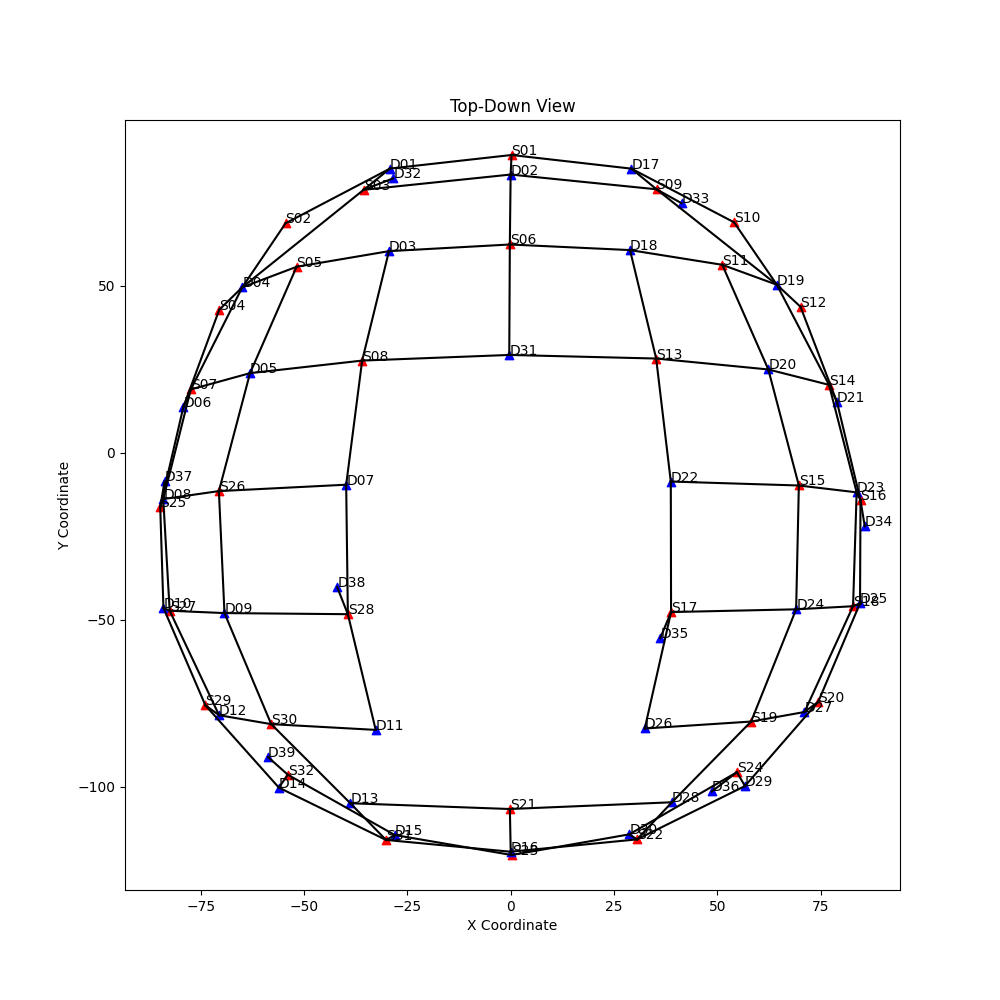

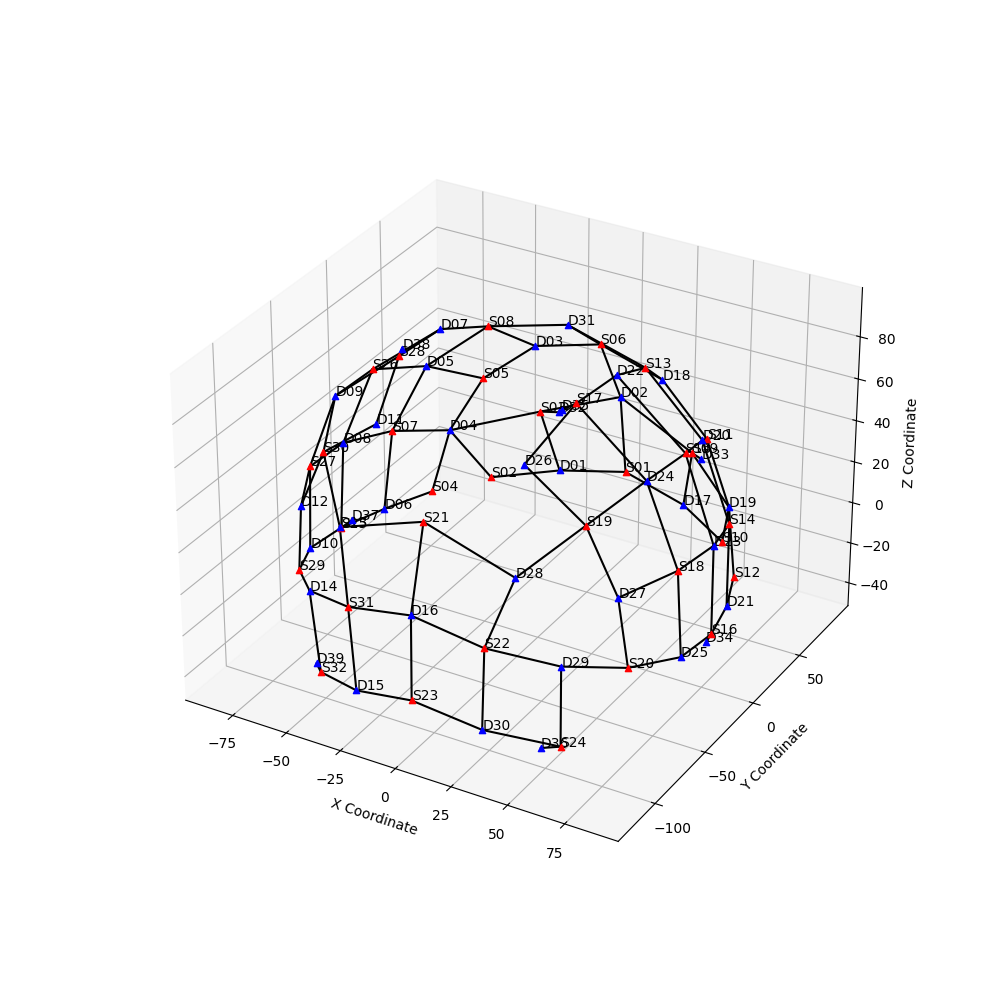

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

def plot_coordinates(view='3d'):
    # Initialize lists to store the channel coordinates and labels
    ch_names = []
    ch_x_coords = []
    ch_y_coords = []
    ch_z_coords = []

    # Open and read the channel file
    with open("C:/Users/super/OneDrive - Ontario Tech University/fNIRS_Emotions/Configurations/Montages/32x32_with_sdcs/Standard_Channels.txt", "r") as file:
        for line in file:
            parts = line.strip().split(',')
            # Each channel is called S(.)_D(.)
            source = f"S{int(parts[1]):02d}"
            detector = f"D{int(parts[2]):02d}"
            ch_names.append(f"{source}_{detector}")
            ch_x_coords.append(float(parts[3]))
            ch_y_coords.append(float(parts[4]))
            ch_z_coords.append(float(parts[5]))

    # Initialize lists to store the optode coordinates and labels
    optode_names = []
    optode_x_coords = []
    optode_y_coords = []
    optode_z_coords = []

    # Open and read the optode file
    with open("C:/Users/super/OneDrive - Ontario Tech University/fNIRS_Emotions/Configurations/Montages/32x32_with_sdcs/Standard_Optodes.txt", "r") as file:
        for line in file:
            parts = line.strip().split(',')
            # Extract coordinates and labels
            optode_name = parts[0]
            if 'S' in optode_name:
                optode_name = f"S{int(optode_name[1:]):02d}"
            elif 'D' in optode_name:
                optode_name = f"D{int(optode_name[1:]):02d}"
            optode_names.append(optode_name)
            optode_x_coords.append(float(parts[1]))
            optode_y_coords.append(float(parts[2]))
            optode_z_coords.append(float(parts[3]))

    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 10))
    
    if view == '3d':
        ax = fig.add_subplot(111, projection='3d')
        # Plot optode points and add their labels
        for i, optode_name in enumerate(optode_names):
            if 'S' in optode_name:
                ax.scatter(optode_x_coords[i], optode_y_coords[i], optode_z_coords[i], marker='^', color='red', label='Sources' if i == 0 else "")
                ax.text(optode_x_coords[i], optode_y_coords[i], optode_z_coords[i], optode_name)
            elif 'D' in optode_name:
                ax.scatter(optode_x_coords[i], optode_y_coords[i], optode_z_coords[i], marker='^', color='blue', label='Detectors' if i == 0 else "")
                ax.text(optode_x_coords[i], optode_y_coords[i], optode_z_coords[i], optode_name)
        # Plot channel lines
        for ch_name in ch_names:
            source, detector = ch_name.split('_')
            source_idx = optode_names.index(source)
            detector_idx = optode_names.index(detector)
            ax.plot([optode_x_coords[source_idx], optode_x_coords[detector_idx]],
                    [optode_y_coords[source_idx], optode_y_coords[detector_idx]],
                    [optode_z_coords[source_idx], optode_z_coords[detector_idx]], color='black')
        # Label axes
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_zlabel('Z Coordinate')
    elif view == '2d':
        ax = fig.add_subplot(111)
        # Plot optode points and add their labels
        for i, optode_name in enumerate(optode_names):
            if 'S' in optode_name:
                ax.scatter(optode_x_coords[i], optode_y_coords[i], marker='^', color='red', label='Sources' if i == 0 else "")
                ax.text(optode_x_coords[i], optode_y_coords[i], optode_name)
            elif 'D' in optode_name:
                ax.scatter(optode_x_coords[i], optode_y_coords[i], marker='^', color='blue', label='Detectors' if i == 0 else "")
                ax.text(optode_x_coords[i], optode_y_coords[i], optode_name)
        # Plot channel lines
        for ch_name in ch_names:
            source, detector = ch_name.split('_')
            source_idx = optode_names.index(source)
            detector_idx = optode_names.index(detector)
            ax.plot([optode_x_coords[source_idx], optode_x_coords[detector_idx]],
                    [optode_y_coords[source_idx], optode_y_coords[detector_idx]], color='black')
        # Label axes
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.set_title('Top-Down View')

    # Display the plot
    plt.show()

# Example usage:
plot_coordinates(view='2d')  # For 2D top-down view
plot_coordinates(view='3d')  # For 3D view